In [1]:
from __future__ import division
import re
import argparse
import os
import glob

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import callbacks as callbacks
from tensorflow.keras.callbacks import Callback

from keras_frcnn import config
from keras_frcnn import losses as losses
from keras_frcnn import resnet as nn
from keras_frcnn import train_helpers
from keras_frcnn.dual_frcnn import Dual_FRCNN
from keras_frcnn.frcnn import FRCNN
from keras_frcnn import CLIP
from keras_frcnn import roi_helpers


from keras_frcnn.tfrecord_parser import get_data
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import random
import cv2

In [2]:
model_type = 'ZSL'
train_path = r'C:\Data_drive\Data'
input_weight_path = r"C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\ZSL\outputs\model\ZSL_FRCNN_epoch129-total_loss-2.26.hdf5"
test_image_path = r"C:\Data_drive\Data\VOCdevkit\test\2008_000037.jpg"

#for tfrecord
'''
record_file = r'C:\Data_drive\Data\xview_train_sample_vehicles.record'

raw_image_dataset = tf.data.TFRecordDataset(record_file)

image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/format': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

def _parse_image_function(raw_image_dataset):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(raw_image_dataset, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

for record in parsed_image_dataset.take(1):
    image = tf.image.decode_jpeg(record['image/encoded']).numpy()
'''

In [3]:
# pass the settings from the command line, and persist them in the config object
C = config.Config()
C.input_weight_path = input_weight_path
C.class_mapping = train_helpers.get_class_map(C, None)

if C.text_dict_pickle is not None:
    C.class_text = train_helpers.get_class_text(C)
else:
    C.class_text = train_helpers.get_class_map(C, r'pascal_class_text.txt')
    
C.class_text = list(C.class_text.keys())
#find the largest class id and add 1 for the background class
num_ids = len(C.training_classes) + 1

#since we are using square images, we know the image size we will be scaling to
input_shape_img = (None, None, 3)
roi_input = Input(shape=(C.num_rois, 4))

optimizer = Adam(learning_rate=1e-5)
#optimizer = Adam(clipnorm=1.0)

#set a very small learning rate for the final pass
full_optimizer = Adam(learning_rate=1e-7, clipnorm=1.0)

print('Building models.')
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
strategy = tf.distribute.get_strategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.

    # define the base network (resnet here)
    base_model = ResNet50(input_shape = input_shape_img, weights='imagenet', include_top=False)

    #freeze the feature extractor
    base_model.trainable = False

    shared_layers = Model(inputs=base_model.inputs, outputs=base_model.get_layer('conv4_block6_out').output)

    # define the RPN, built on the base layers
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
    rpn = nn.rpn(shared_layers.output, num_anchors)
    model_rpn = Model(shared_layers.input, rpn[:2])

    if model_type == 'ZSL':
        classifier_ZSL = nn.classifier_ZSL(shared_layers.output, roi_input, C.num_rois, C.num_projection_layers, C.projection_dims, C.dropout_rate, nb_classes=num_ids, trainable=True)
        # this is a model that holds both the RPN and the classifier, used to train the model end to end
        model_all = Model([shared_layers.input, roi_input], rpn[:2] + classifier_ZSL)
        #build the text encoder
        text_base_embedding, text_encoder = CLIP.create_text_encoder(C)
        C.bert_embeddings = text_base_embedding.predict(tf.convert_to_tensor(C.class_text))


    else:
        classifier = nn.classifier(shared_layers.output, roi_input, C.num_rois, nb_classes=num_ids, trainable=True)
        # this is a model that holds both the RPN and the classifier, used to train the model end to end
        model_all = Model([shared_layers.input, roi_input], rpn[:2] + classifier)

if model_type == 'ZSL':
    with strategy.scope():
        model = Dual_FRCNN(model_rpn, model_all, text_encoder, C)
        model.compile(optimizer= optimizer, run_eagerly = True)
else:
    with strategy.scope():
        model = FRCNN(model_rpn, model_all, C)
        model.compile(optimizer= optimizer, run_eagerly=True)

print('Models sucessfully built.')
start_epoch = 0
#check if model has already started training by checking for a model in the outputs folder
if os.path.isdir('./outputs/model/') and C.input_weight_path is None:

    fine_tune = None
    epoch_weights = None
    files = glob.glob('./outputs/model/*')
    
    for file in files:
        fine_tune = re.search('fine_tune_epoch', file)
        if fine_tune is not None:
            fine_tune_weights = file
        else:
            epoch = int(re.search('epoch(.+?)-', file).group(1))
            
            if epoch >= start_epoch:
                epoch_weights = file
                start_epoch = epoch
    if fine_tune is not None:
        start_epoch = 0
        C.input_weight_path = fine_tune_weights
    else:
        C.input_weight_path = epoch_weights

#load weights to the model
try:
    if (C.input_weight_path == None):
        print('Loaded imagenet weights to the vision backbone.')
    else:
        model.built = True
        if model_type == 'FRCNN':
            model.load_weights(C.input_weight_path, by_name=True)
            print(f'loading FRCNN weights from {C.input_weight_path}')
        else:
            if (C.input_weight_path == None):
                print('Loaded imagenet weights to the vision backbone.')
                print('Loaded pretrained BERT weights to the text encoder.')
            else:
                model.load_weights(C.input_weight_path, by_name=True, skip_mismatch=True)
                print(f'loading dual encoder weights from {C.input_weight_path}')
except:
    print('Could not load pretrained model weights.')
    exit()

Building models.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 1
Models sucessfully built.
loading dual encoder weights from C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\ZSL\outputs\model\ZSL_FRCNN_epoch129-total_loss-2.26.hdf5


In [4]:
#if this is 0, restart the kernel, the weights failed to load properly
model_all.get_layer('dense_embedding_projection').weights[1].numpy()[0]

-0.00019275473

# Embed the text strings

In [104]:
print(f"Generating embeddings for {len(C.class_text)} labels...")
text_embeddings = text_encoder.predict(C.bert_embeddings)
#normalize the text embedding

#text_embeddings = tf.math.l2_normalize(text_embeddings, axis=1, epsilon = 1e-4)
print(f"Text embeddings shape: {text_embeddings.shape}.")

Generating embeddings for 21 labels...
Text embeddings shape: (21, 256).


In [105]:
print(text_embeddings[0])

[-1.1589605   0.63820964  0.40600002  0.6575161   1.0134398  -0.2832626
 -0.02467693  0.06803018  0.03568634  0.5149682  -3.2810571   0.2386368
  0.11482979  0.31274444  0.17637789  0.75680864  0.25704518 -2.1889057
  1.103091   -2.2798026   0.49371445  0.25177878  0.30623934  0.62550306
 -0.21942633  0.30671182  0.7347445   0.34544918  0.4232656   0.45640045
  0.9890909  -0.15568356 -0.400519    0.40988353 -0.93811643  0.06593112
 -1.4973383   0.19098765 -0.24664675 -0.60081387  0.32401633  0.25906864
 -0.18743956  0.60790217  0.5950948   1.1134818   0.96956694  0.3466803
 -0.79261297  0.28076714  0.8469948   0.61709285  0.6270028   0.3163172
  0.33674103  1.1345049  -0.48881945  0.9971294  -3.1324575  -0.15398902
  0.63436115 -0.49308816  0.0926732   0.6434845  -2.483163    0.36719227
 -0.44136038 -1.127358    0.01456107 -0.09212722  0.22872522 -0.17048171
 -3.8001716   0.61623263  0.23672338  0.59799844 -3.652961    0.34405383
 -0.5064231  -0.32265416  0.48509106  0.39737293  0.9748


# Embed the image

In [83]:
try: image
except NameError: image = tf.image.decode_jpeg(tf.io.read_file(test_image_path), channels=3)

image_array = tf.image.resize(image, (C.im_size, C.im_size))

image_tensor = tf.convert_to_tensor(image_array)

#reshape because the first dimension is batch size
image_tensor = image_tensor[None,:,:,:]

P_rpn = model_rpn.predict(image_tensor)

#regions_of_interest input and output are in feature space
regions_of_interest = roi_helpers.rpn_to_roi(C, P_rpn[0], P_rpn[1], use_regr=True, overlap_thresh=0.5, max_boxes=C.num_rois)

roi_tensor = tf.convert_to_tensor(regions_of_interest)
#reshape because the first dimension is batch size
roi_tensor = roi_tensor[None,:,:]

model_preds = model_all.predict([image_tensor, roi_tensor])
epsilon = 1e-4

model_preds[2][0] = tf.math.l2_normalize(model_preds[2][0], axis=0, epsilon = 1e-4)

print(f"Image embeddings shape: {model_preds[2][0].shape}.")

Image embeddings shape: (4, 256).


# Find the similarity

In [97]:
#for roi in range(model_preds[2][0].shape[0])
dot_similarity = tf.matmul(100 * model_preds[2][0], text_embeddings, transpose_b=True)
true_probs = tf.keras.activations.softmax(dot_similarity, axis=1)
results = []
probs = []
results_topk = []
probs_topk = []

for roi in range(true_probs.shape[0]):
    results.append(tf.math.top_k(dot_similarity[roi], 1).indices.numpy())
    probs.append(tf.math.top_k(true_probs[roi], 1).values.numpy())
    results_topk.append(tf.math.top_k(dot_similarity[roi], 5).indices.numpy())
    probs_topk.append(tf.math.top_k(true_probs[roi], 5).values.numpy())

In [98]:
true_probs

<tf.Tensor: shape=(4, 21), dtype=float32, numpy=
array([[0.74030596, 0.01166816, 0.01772746, 0.00669885, 0.02485525,
        0.04699067, 0.00798856, 0.01344259, 0.00826345, 0.01358136,
        0.01361508, 0.01309023, 0.00565068, 0.00840299, 0.01162536,
        0.00418624, 0.01591097, 0.01256968, 0.00651506, 0.0054403 ,
        0.01147117],
       [0.62787807, 0.04323905, 0.01168476, 0.00940998, 0.06760678,
        0.01304136, 0.01728231, 0.01416426, 0.00387246, 0.00576783,
        0.00608252, 0.02510023, 0.0020043 , 0.01759439, 0.00345209,
        0.00143681, 0.00437978, 0.00536189, 0.01068465, 0.01719803,
        0.09275857],
       [0.42673898, 0.00768165, 0.02093257, 0.02665563, 0.03533482,
        0.04372848, 0.01481908, 0.02428171, 0.03865767, 0.01225896,
        0.03910254, 0.00932593, 0.02928303, 0.03795926, 0.02018799,
        0.03479308, 0.0543405 , 0.05506828, 0.01309537, 0.02481629,
        0.03093817],
       [0.54992884, 0.0134167 , 0.02948455, 0.0119049 , 0.0361597 ,
    



# Show the image

(-0.5, 499.5, 443.5, -0.5)

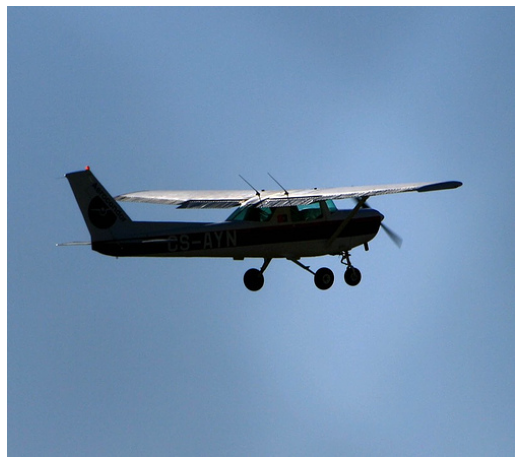

In [96]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(test_image_path).convert("RGB")

#set the image size
plt.figure(figsize=(20, 10))


#show the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")

In [92]:
def draw_boxes(image, bboxes, ids, labels, probs, min_prob):
    import cv2
    import matplotlib.pyplot as plt

    window_name = 'Image'

    image = np.copy(image)

    # font needed for text
    font = cv2.FONT_HERSHEY_SIMPLEX

    import re
    pattern = r".* with features"

    for i, result in enumerate(ids):       
        res = re.search('A (.+?) with features', labels[result[0]])
        textLabel = res.group(1)
        print(str(probs[i]) + " " + textLabel)
        #dont display if its labeled background
        if textLabel == 'bg':
            continue
        #ignore low probability hits
        if probs[i] <= min_prob: 
            continue
            
        print(labels[result[0]])
        x1 = bboxes[i][0] * image.shape[1] / P_rpn[1].shape[1]
        y1 = bboxes[i][1] * image.shape[0] / P_rpn[1].shape[2]
        x2 = bboxes[i][2] * image.shape[1] / P_rpn[1].shape[1]
        y2 = bboxes[i][3] * image.shape[0] / P_rpn[1].shape[2]

        topleft = (int(x1), int(y1))
        bottomright = (int(x2), int(y2))
        textOrg = (int(x1), int(y1))
        #This is the truth
        image = cv2.rectangle(image, topleft, bottomright, color=(0, 0, 255), thickness=1)
        image = cv2.putText(image, textLabel, textOrg, font, fontScale = 1, color=(0, 0, 255))
        # Display the image 

    plt.figure(figsize=(20, 10))
    plt.imshow(image)

[0.74030596] bg
[0.62787807] bg
[0.42673898] bg
[0.54992884] bg


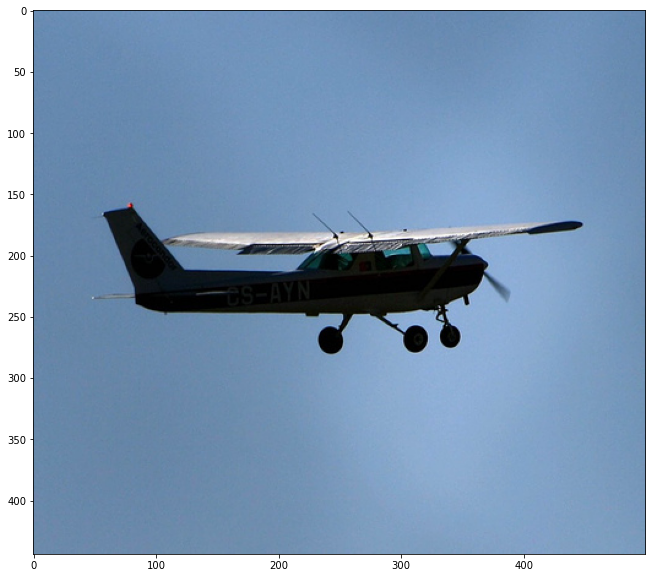

In [99]:
draw_boxes(image, regions_of_interest, results, C.class_text, probs, .8)

In [ ]:
#show the probabilities
plt.subplot(1, 2, 2)
for i in range(len(probs)):
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in results])
    plt.xlabel("probability")

plt.show()